# 0. Initialize

In [1]:
#@title Connect to gDrive & Load Files
ENV_COLAB = 'google.colab' in str(get_ipython())
if ENV_COLAB:
    print('Running on CoLab')
    PROJECT_DRIVE_FOLDER= "/content/drive/MyDrive/NiPAMS/BP development/analysis/nipams-bp-py-main/" #@param {"type":"string"}
    ## Load this for local development version of library.. Loads from GoogleDrive (changes persist)
    from google.colab import drive, widgets, data_table; 
    drive.mount('/content/drive');
    %cd "$PROJECT_DRIVE_FOLDER"
  
    !pip install -qr requirements.txt
    !pip install -q envyaml
    import os, sys; 
    from envyaml import EnvYAML; env = EnvYAML('env/default.yml'); 
    for k,v in env.export().items(): os.environ[k]=str(v)
    sys.path.append(os.path.abspath("./src"))

else:
    print('Not running on CoLab')
    %cd /app
!pwd

from importlib import reload;
from utils.constants import *

Running on CoLab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main
/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main


In [2]:
!pip install tsai -Uq
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.3.4
fastai     : 2.7.10
fastcore   : 1.5.27
torch      : 1.13.0+cu116


In [3]:
from data import load_data, preprocess; reload(load_data);reload(preprocess)
from models import experiments; reload(experiments)

<module 'models.experiments' from '/content/drive/.shortcut-targets-by-id/1MnayBGJfAervEVUyYNEibuPedW7NJuzm/NiPAMS/BP development/analysis/nipams-bp-py-main/src/models/experiments.py'>

# 1. Load & Process Data

In [4]:
dfBpCont, dfImuCont = load_data.load_dataframe_from_mat(folder='data/raw_mat/', pattern=f'{"LV"}\d+.mat', limit_files=10)
dfAll = preprocess.merge_imu_vcg_with_heartbeats(dfBpAll=dfBpCont, dfImuAll=dfImuCont)

In [7]:
dfImu = dfAll[INDICIES + IMU_DATA_COLS + ['ts']].reset_index(drop=True)
dfBp = dfAll[INDICIES + BP_COLS + ['ts']].reset_index(drop=True)

dfImu.update(dfImu.groupby('file', sort=False)[IMU_DATA_COLS].transform(lambda x : (x-x.mean())/x.std()))
dfImuSamp, dfBpSamp = preprocess.interpolateDatasets(dfImu.set_index('ts'), dfBpCont.set_index('ts'))
dfImuSamp, dfBpSamp = dfImuSamp.reset_index().set_index('ts'), dfBpSamp.drop('file',axis=1).reset_index().set_index('ts')
#@title Merge IMU and BP Datasets by TimeStamp
# https://stackoverflow.com/questions/38833362/merge-dataframes-on-nearest-datetime-timestamp
def reindex_imu(inds, df, dfRef):
  return df.reset_index().set_index(['ts']).reindex(dfRef.loc[inds].reset_index().set_index(['ts']).index, method='nearest')

dfImuSampReind = dfImuSamp.reset_index().set_index(['file','ts'])
arrdfs = []
for inds, df in dfBpSamp.groupby('file'):
  try :
    dfReind = reindex_imu(inds, df, dfImuSampReind)
    arrdfs.append(dfReind.reset_index())
  except KeyError as e: 
    print("Failed to Process file : ", inds, str(e))


dfBpSampReind = pd.concat(arrdfs)
# dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'])
dfReind = pd.merge(dfBpSampReind, dfImuSamp, on=['file','ts'], suffixes=('','_drop'))
dfReind = dfReind.drop(columns=dfReind.columns[dfReind.columns.str.contains('_drop')])

dfImu = dfReind[['ts'] + INDICIES + IMU_DATA_COLS].reset_index(drop=True)
dfBp = dfReind[['ts'] + INDICIES + BP_COLS].reset_index(drop=True)

# 2. Manual Train & Test for Neural Network

## Setup Splits & ML Model

In [8]:
from tsai.data.preparation import SlidingWindowPanelSplitter

TARGET = 'sbp'

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = [TARGET]
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(window_len=190, unique_id_cols=['file'], stride=100, 
                                  get_x=arrX,
                                  get_y=[TARGET])(dfReind)

splits_tsai = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


In [9]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits_tsai, tfms=tfms, batch_tfms=batch_tfms, bs=64)
# dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=5)

X.shape, y.shape

((898, 6, 190), (898,))

## Model Init & Train

epoch,train_loss,valid_loss,mae,_rmse,time
0,1.117874,1.061007,0.841349,1.030052,00:08
1,1.116272,1.111039,0.859337,1.054058,00:00
2,1.108348,1.161078,0.873100,1.077533,00:00
3,1.095176,1.170577,0.872325,1.081932,00:00
4,1.072232,1.114203,0.856524,1.055558,00:00
5,1.042618,1.032109,0.830494,1.015928,00:00
6,1.010406,0.951594,0.801025,0.975497,00:00
7,0.976533,0.886984,0.769840,0.941798,00:00
8,0.938827,0.843156,0.746014,0.918235,00:00
9,0.900296,0.799876,0.722825,0.894358,00:00


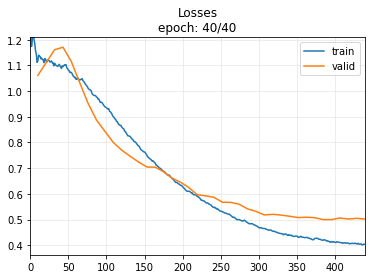

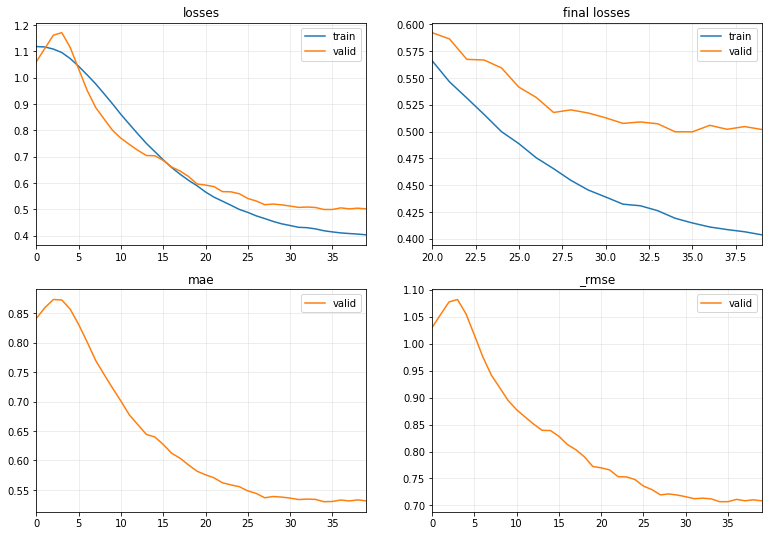

In [10]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(40, 1e-5)

## Model Evaluation & Predict Test Set

In [11]:
def unnorm_y(ser): return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits_tsai[1]])
yTarget, yPreds = unnorm_y(y[splits_tsai[1]]), unnorm_y(np.array(preds).flatten())

In [12]:
dfRes_ = pd.DataFrame([yTarget, yPreds], index=[f'{TARGET}_actuals',f'{TARGET}_preds']).T
dfRes = pd.merge(dfBp, dfRes_, left_on=TARGET, right_on=f'{TARGET}_actuals').drop_duplicates(INDICIES).set_index(INDICIES)
dfRes = dfRes.assign(fold_number=0)
dfRes

ts         pp         sbp  \
file            heartbeat                                                 
sub019_HLV1.mat 7.0       0 days 00:00:06.211000  59.474483  116.649678   
                8.0       0 days 00:00:07.106000  59.474483  116.649678   
                17.0      0 days 00:00:15.896000  57.650219  123.746984   
                18.0      0 days 00:00:16.751000  57.650219  123.746984   
                19.0      0 days 00:00:17.676000  55.082525  121.465258   
...                                          ...        ...         ...   
sub112_LLV3.mat 21.0      0 days 00:00:17.454000  55.271220  125.784450   
                22.0      0 days 00:00:18.259000  46.622441  117.782534   
                23.0      0 days 00:00:19.154000  51.727253  124.533965   
                24.0      0 days 00:00:19.859000  51.727253  124.533965   
                25.0      0 days 00:00:20.669000  52.786742  126.539020   

                                 dbp  sbp_actuals   sbp_preds  fold_number  
file            heartbeat                                                   
sub019_HLV1.mat 7.0        57.175195   116.649678  120.265699            0  
                8.0        57.175195   116.649678  120.265699            0  
                17.0       66.096765   123.746984  124.997385            0  
                18.0       66.096765   123.746984  124.997385            0  
                19.0       66.382733   121.465258  124.609188            0  
...                              ...          ...         ...          ...  
sub112_LLV3.mat 21.0       70.513230   125.784450  125.824239            0  
                22.0       71.160092   117.782534  123.411984            0  
                23.0       72.806712   124.533965  122.309462            0  
                24.0       72.806712   124.533965  122.309462            0  
                25.0       73.752278   126.539020  122.963622            0  

[284 rows x 7 columns]

# Run in Loop

In [13]:
STOP_HERE

NameError: ignored

In [ ]:
from tsai.data.preparation import SlidingWindowPanelSplitter

TARGET = 'dbp'

arrX = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
arrY = [TARGET]
dfReind[arrX + arrY] = dfReind[arrX + arrY].fillna(method='ffill').fillna(method='bfill')
# https://timeseriesai.github.io/tsai//data.preparation#SlidingWindowPanel
# X, y = SlidingWindowPanel(600, unique_id_cols=['file'], stride=200, 
X, y = SlidingWindowPanelSplitter(window_len=190, unique_id_cols=['file'], stride=100, 
                                  get_x=arrX,
                                  get_y=[TARGET])(dfReind)

splits_tsai = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

# Normalize y's
y_raw = y.copy()
y = (y - y.mean()) / y.std()
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_var=True)
dls = get_ts_dls(X, y, splits=splits_tsai, tfms=tfms, batch_tfms=batch_tfms, bs=64)
# dls = get_ts_dls(X, y, tfms=tfms, batch_tfms=batch_tfms, bs=5)

X.shape, y.shape
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.fit_one_cycle(20, 1e-5)
def unnorm_y(ser): return (ser*y_raw.std()+y_raw.mean())

probas, _, preds = learn.get_X_preds(X[splits_tsai[1]])
yTarget, yPreds = unnorm_y(y[splits_tsai[1]]), unnorm_y(np.array(preds).flatten())
dfRes_ = pd.DataFrame([yTarget, yPreds], index=[f'{TARGET}_actuals',f'{TARGET}_preds']).T
dfRes = pd.merge(dfBp, dfRes_, left_on=TARGET, right_on=f'{TARGET}_actuals').drop_duplicates(INDICIES).set_index(INDICIES)
dfRes = dfRes.assign(fold_number=0)
dfRes

In [ ]:
dfResults = dfResults1\
  .merge(dfResults2, left_index=True, right_index=True, suffixes=('','_drop1'))\
  .merge(dfResults3, left_index=True, right_index=True, suffixes=('','_drop2'))\
  .assign(**{
      'experiment_id' : id,
      'pipeline' : ', '.join([i[0] for i in pipeVectRF.steps])
  })

dfResults = dfResults.drop(columns=dfResults.columns[dfResults.columns.str.contains('_drop')])
dfResults = dfResults.reset_index()
dfResults.file = dfResults.file.str.extract(pat='/[0-9]+_CCs_(sub[0-9]+_\w+).mat$')


# Sklearn Pipeline

## Wrap Model as Sklearn Pipeline

In [17]:
from sklearn.base import BaseEstimator

# https://scikit-learn.org/stable/developers/develop.html
class TSAI_InceptionTime(BaseEstimator):
  def __init__(self, target='sbp'):
    self.target = target

  def setup_dls(self, X, y):
    tfms  = [None, [TSRegression()]]
    batch_tfms = TSStandardize(by_var=True)
    splits = TrainValidTestSplitter(valid_size=0.2, shuffle=True)(y)

    dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=20)
    return dls


  def fit(self, X, y):
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    
    X = X[:,1:,:].astype(np.float32)
    y = y.values
    
    print('TSAI.fit X', X.dtype, X.shape)
    print('TSAI.fit y', y.dtype, y.shape)
    self.y_train = y
    y = (y - y.mean()) / y.std()

    self.dls = self.setup_dls(X, y)
    
    self.learn = ts_learner(self.dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
    self.learn.fit_one_cycle(20, 1e-3)

    return self

  def predict(self, X):
    # X = X[:,:,1:].astype(np.float32)
    X = X[:,1:,:].astype(np.float32)
    
    probas, _, preds = self.learn.get_X_preds(X)
    yPreds = self.unnorm_y(np.array(preds).flatten())
    return np.array(yPreds).clip(40,180)
    

  def unnorm_y(self, ser):
    return (ser*self.y_train.std()+self.y_train.mean())

  ## TODO : proper scoring method
  ## TODO : also this breaks the mvd method somehow?
  def score(self, rows, y):
    # return 1
    return np.abs((self.predict(rows))-y).fillna(0).mean()

## Get Splits for Experiment

In [28]:
RUN_NAME = "-LV_tmp_dec12"
FILE_PROCESSED = f'data/interim/{RUN_NAME}.pickle'
dfAll = load_data.load_dataframe_from_pickle(path=FILE_PROCESSED)
dfImu = dfAll[INDICIES + INFO_COLS + IMU_COLS]
dfBp = dfAll[INDICIES + INFO_COLS + BP_COLS]

In [31]:
reload(experiments)
# splits = experiments.split_by_random(dfImu, dfBp)
splits = experiments.split_by_group(dfBp=dfBp, **{**json.loads(experiments.DEFAULTS['split_by_group'])['kwargs'], 'split_kwargs':{'n_splits':3}})
# splits = experiments.split_by_group('file', dfImu, dfBp, split_kwargs={'n_splits':4})

# splits = experiments.split_by_query(trainQ='heartbeat < 30', testQ='heartbeat > 30', dfImu=dfImu, dfBp=dfBp, )
# objExperimentDfs = experiments.get_experiment(splits[0], dfImu, dfBp)
# objExperimentDfs['train_y'].groupby(INDICIES, sort=False)['sbp'].mean()
# objExperimentDfs['train_x'].drop(, errors='ignore')

## Train & Test TSAI Pipeline

In [34]:
from models import nn_tsai; reload(nn_tsai)
tsai_model = nn_tsai.TSAI_InceptionTime()

TSAI.fit X object (399, 7, 190)
TSAI.fit y float32 (399,)
TSAI.fit X float32 (399, 6, 190)
TSAI.fit y float32 (399,)


epoch,train_loss,valid_loss,mae,_rmse,time
0,1.173887,0.866823,0.847826,0.931033,00:00
1,0.703073,0.295796,0.455429,0.543871,00:00
2,0.456439,0.228338,0.351262,0.477848,00:00
3,0.331432,0.276607,0.467713,0.525934,00:00
4,0.267295,0.072903,0.205945,0.270005,00:00
5,0.225103,0.214811,0.406071,0.463477,00:00
6,0.187800,0.074625,0.208793,0.273176,00:00
7,0.157502,0.099853,0.237459,0.315995,00:00
8,0.128736,0.097604,0.238276,0.312416,00:00
9,0.112710,0.086782,0.216201,0.294587,00:00


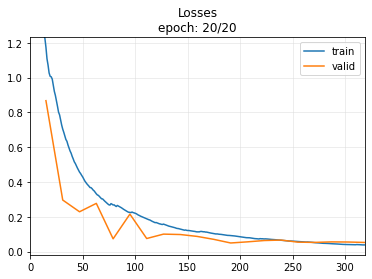

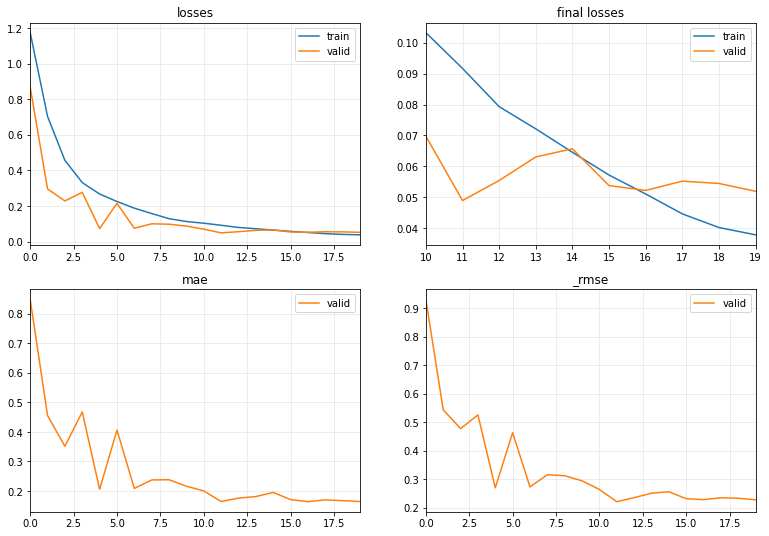

mean_absolute_error, r2_score :  24.363 -282.771
TSAI.fit X object (574, 7, 190)
TSAI.fit y float32 (574,)
TSAI.fit X float32 (574, 6, 190)
TSAI.fit y float32 (574,)


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.644372,0.716510,0.742278,0.846469,00:00
1,0.371282,0.140774,0.309741,0.375198,00:00
2,0.243561,0.163933,0.317037,0.404886,00:00
3,0.187636,0.085237,0.234658,0.291954,00:00
4,0.151394,0.141718,0.312217,0.376454,00:00
5,0.130499,0.128060,0.283231,0.357855,00:00
6,0.110159,0.114591,0.281459,0.338513,00:00
7,0.093828,0.074374,0.209038,0.272716,00:00
8,0.079811,0.068956,0.199889,0.262596,00:00
9,0.072335,0.124962,0.272825,0.353500,00:00


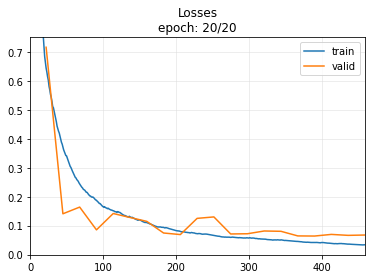

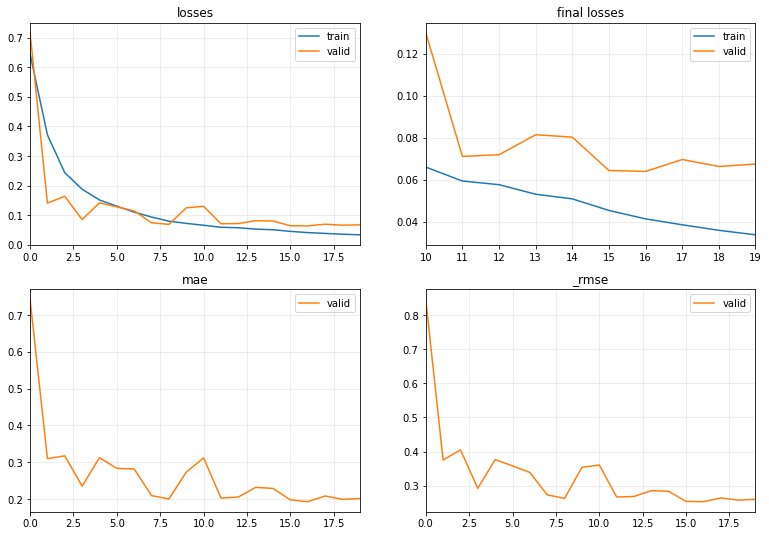

mean_absolute_error, r2_score :  24.408 -33.389
TSAI.fit X object (583, 7, 190)
TSAI.fit y float32 (583,)
TSAI.fit X float32 (583, 6, 190)
TSAI.fit y float32 (583,)


epoch,train_loss,valid_loss,mae,_rmse,time
0,0.832771,0.587448,0.613673,0.766452,00:00
1,0.742862,0.445946,0.538039,0.667792,00:00
2,0.670158,0.434819,0.515614,0.659408,00:00
3,0.641996,1.018022,0.780590,1.008971,00:00
4,0.605319,0.349816,0.469191,0.591452,00:00
5,0.595737,0.668298,0.631163,0.817495,00:00
6,0.565474,0.484223,0.566323,0.695861,00:00
7,0.562145,0.370083,0.485718,0.608344,00:00
8,0.543654,0.430694,0.517158,0.656273,00:00
9,0.508447,0.315573,0.448203,0.561759,00:00


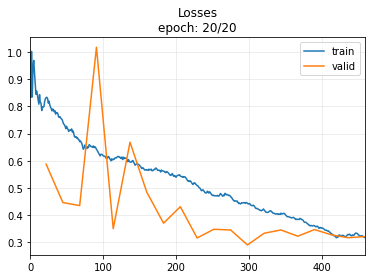

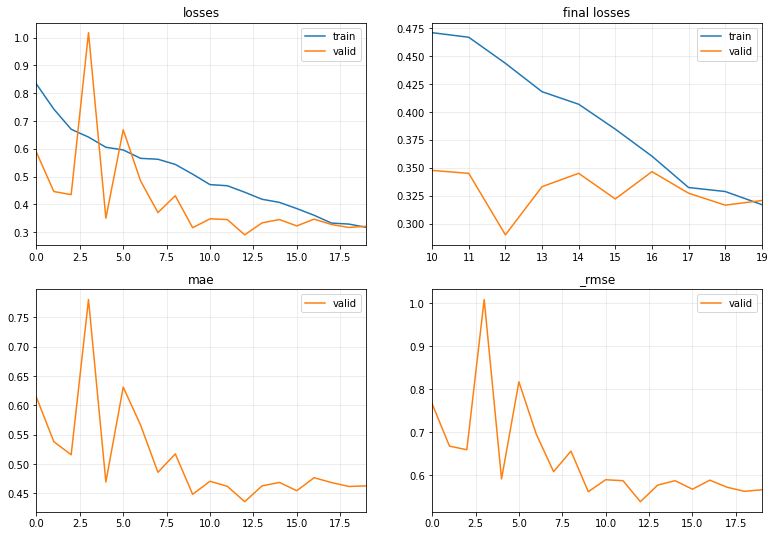

mean_absolute_error, r2_score :  31.282 -1453.312


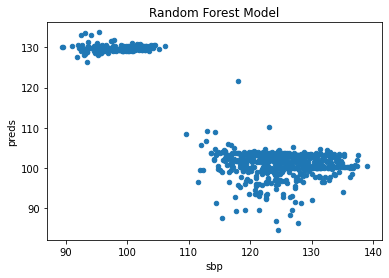

In [35]:
reload(experiments); reload(preprocess)
from models import baselines
import sklearn.pipeline
tsExplodeTransform = preprocess.FunctionTransformer(partial(preprocess.explode_3d, data_cols=IMU_DATA_COLS))
tsReshape = preprocess.FunctionTransformer(lambda x : x.transpose(0,2,1))
# pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform), ('model', baselines.DummyRegressor())])
# pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform),('transform-reshape', tsReshape), ('model', TSAI_InceptionTime())])
pipe = sklearn.pipeline.Pipeline([('transform', tsExplodeTransform),('transform-reshape', tsReshape), ('model', tsai_model)])

rfResults = experiments.testPipeline(dfImu, dfBp, pipe, splits, targetCol='sbp', verbose=True)
dfResults = experiments.resultsToDf(rfResults)
dfResults.plot.scatter('sbp','preds', title='Random Forest Model')